# Graph-Sparse Logistic Regression applied to the real proteomics data from the TCGA/CPTAC Ovarian Cancer dataset. 

In [1]:
%pylab inline

import sys
import pickle
import pandas as pd
import networkx as nx

from sklearn.preprocessing import LabelEncoder

from matplotlib_venn import venn3, venn3_circles, venn2

repo_path = '/Users/alex/Documents/gslr/'
interactome_path = repo_path + 'experiments/algorithms/pcsf/inbiomap_temp.tsv'

sys.path.append(repo_path + 'gslr/')
import gslr

Populating the interactive namespace from numpy and matplotlib


### i. Load Datasets

In [2]:
# medullo = pd.read_csv('/Users/alex/Documents/proteomics/data_preparation/proteomics_data/medullo_inbiomap_exp.tsv', index_col=0)
ovarian = pd.read_csv('/Users/alex/Documents/proteomics/data_preparation/proteomics_data/ovarian_inbiomap_exp.tsv', index_col=0)
# brca = pd.read_csv('/Users/alex/Documents/proteomics/data_preparation/proteomics_data/brca_inbiomap_exp.tsv', index_col=0)

# medullo_labels = pd.read_csv('/Users/alex/Documents/proteomics/data_preparation/proteomics_data/raw/medullo_labels.csv', index_col=0)
ovarian_labels = pd.read_csv('/Users/alex/Documents/proteomics/data_preparation/proteomics_data/raw/ovarian_labels.csv', index_col=0)
# brca_labels = pd.read_csv('/Users/alex/Documents/proteomics/data_preparation/proteomics_data/raw/brca_labels.csv', index_col=0)

### ii. Load Interactome

In [3]:
inbiomap_experimentally = pd.read_csv(interactome_path, sep='\t', names=['protein1','protein2','cost'])
inbiomap_experimentally.head()

,protein1,protein2,cost
0,ZNF91,NDEL1,1.253
1,ZNF91,ELAVL1,1.254
2,ZNF91,SUMO1,1.245
3,ZNF91,SUMO3,1.245
4,ZNF91,CHMP5,1.241


In [4]:
(edges, nodes) = pd.factorize(inbiomap_experimentally[["protein1","protein2"]].unstack())
edges = edges.reshape(inbiomap_experimentally[["protein1","protein2"]].shape, order='F')
edges

array([[    0,  1228],
       [    0,  1279],
       [    0,  4071],
       ..., 
       [14190, 14237],
       [14191, 14378],
       [14192, 14539]])

## I. TCGA Ovarian

In [5]:
dataset = ovarian.copy()
labels = ovarian_labels.copy()
dataset.shape, labels.shape

((206, 16349), (206, 1))

### i. Prepare Dataset

In [6]:
dataset = dataset.transpose().reindex(index=nodes).transpose()
X = dataset.values
dataset.head()

,ZNF91,ACP5,SLC27A2,PAX9,ADAM15,ELOVL2,DDX60L,FGF7,CDHR5,LYPD3,...,CNR2,GIG44,LINC00588,TAAR2,CHRNE,ANKAR,DHH,CYSLTR1,COL23A1,MEDAG
PNNL-TCGA-09-1664,0.0,0.000,0.0000,0.0,0.279,0.0,0.000,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PNNL-TCGA-13-1484,0.0,0.175,0.0000,0.0,0.000,0.0,-0.443,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PNNL-TCGA-13-1488,0.0,0.000,0.0000,0.0,-0.462,0.0,0.621,0.0,0.0,-0.398,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PNNL-TCGA-13-1489,0.0,0.000,-0.2670,0.0,0.000,0.0,-0.601,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PNNL-TCGA-13-1494,0.0,0.000,0.0117,0.0,0.053,0.0,-1.260,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
labels = labels.values.flatten().tolist()

In [8]:
labeler = LabelEncoder()
labeler.fit(labels)
y = labeler.transform(labels)
y

array([0, 1, 2, 0, 2, 2, 2, 2, 1, 0, 0, 0, 0, 1, 2, 2, 0, 3, 2, 4, 4, 0, 0,
       0, 2, 2, 4, 0, 0, 4, 3, 0, 0, 3, 3, 2, 0, 1, 2, 1, 3, 5, 4, 2, 0, 4,
       2, 4, 2, 0, 4, 0, 1, 2, 3, 3, 0, 4, 3, 3, 0, 2, 2, 2, 0, 1, 2, 4, 2,
       1, 1, 2, 0, 3, 3, 1, 0, 0, 2, 1, 0, 5, 0, 2, 0, 5, 1, 3, 2, 2, 2, 2,
       2, 2, 0, 3, 2, 1, 2, 2, 2, 1, 0, 0, 1, 1, 1, 3, 3, 2, 0, 0, 2, 2, 0,
       2, 1, 0, 4, 5, 3, 0, 0, 0, 3, 2, 5, 1, 1, 0, 3, 0, 1, 2, 1, 0, 3, 0,
       0, 0, 4, 0, 4, 2, 0, 4, 0, 1, 4, 0, 1, 0, 2, 0, 3, 2, 3, 2, 2, 0, 3,
       0, 2, 4, 1, 2, 0, 2, 1, 3, 2, 2, 0, 0, 3, 4, 1, 2, 1, 1, 1, 0, 0, 0,
       1, 3, 0, 0, 4, 0, 3, 0, 1, 3, 1, 3, 0, 0, 1, 0, 1, 0, 1, 3, 1, 4])

### ii. Graph-Sparse Logistic Regression

In [9]:
d = len(nodes)
c = 6

graph_opts = gslr.GraphOptions(edges=edges, root=-1, num_clusters=1, pruning='strong')

sparsity_low = 150
sparsity_high = 350

verbosity_level = 1

num_steps = 25
possible_steps = np.array([0.03, 0.1, 0.3])
steps = np.tile(possible_steps, (num_steps, 1))

W0 = np.zeros((c, d))

In [13]:
W_hat, losses = gslr.gslr(X, y, W0, sparsity_low, sparsity_high, graph_opts, steps, verbosity_level, edge_costs=inbiomap_experimentally.cost.values, edge_costs_multiplier=6)

iteration 1:
  loss_cur = 1.7917594692280547   loss_next = 1.4256852914386093   step_size = 0.03
  loss_cur = 1.7917594692280547   loss_next = 0.95813951350749   step_size = 0.1
  loss_cur = 1.7917594692280547   loss_next = 0.8407761163206704   step_size = 0.3
  best_step_size: 0.3
iteration 2:
  loss_cur = 0.8407761163206704   loss_next = 0.742234938876066   step_size = 0.03
  loss_cur = 0.8407761163206704   loss_next = 0.6400959210765067   step_size = 0.1
  loss_cur = 0.8407761163206704   loss_next = 1.778614247420891   step_size = 0.3
  best_step_size: 0.1
iteration 3:
  loss_cur = 0.6400959210765067   loss_next = 0.60821942037204   step_size = 0.03
  loss_cur = 0.6400959210765067   loss_next = 0.5568396052721837   step_size = 0.1
  loss_cur = 0.6400959210765067   loss_next = 0.7335156968447939   step_size = 0.3
  best_step_size: 0.1
iteration 4:
  loss_cur = 0.5568396052721837   loss_next = 0.5869699061685455   step_size = 0.03
  loss_cur = 0.5568396052721837   loss_next = 0.518323

Train accuracy: 0.9757281553398058


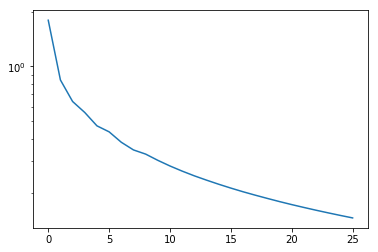

In [14]:
yhat = gslr.predict(X, W_hat)
num_cor = gslr.num_correct(y, yhat)
print('Train accuracy: {}'.format(num_cor / float(len(y))))

plt.plot(losses)
plt.yscale('log')

### iii. Unpack Results

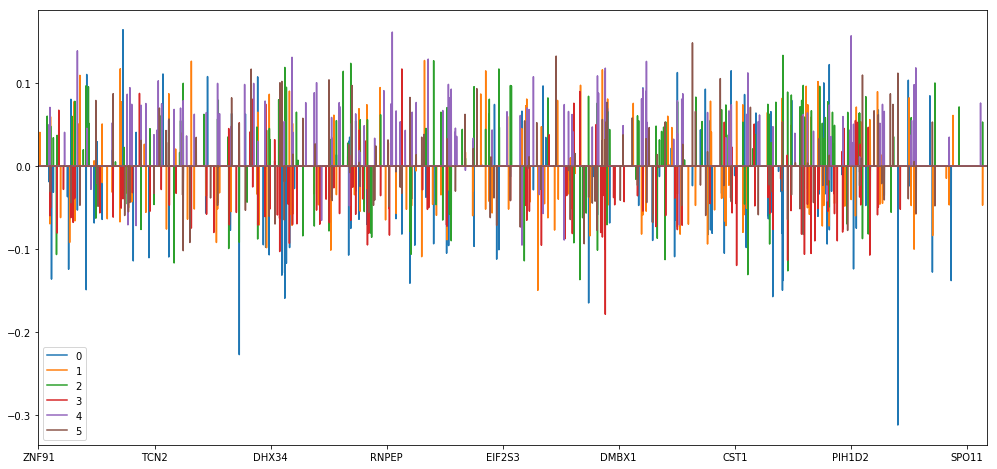

In [15]:
coefs = pd.DataFrame(W_hat, columns=dataset.columns)
coefs.transpose().plot(figsize=(17,8))

In [16]:
features = coefs.columns[(coefs != 0).any()].tolist()
len(features)

592

In [5]:
features

['SLC25A6',
 'MICAL1',
 'LRP1',
 'SERPIND1',
 'DCN',
 'HLA-DRB1',
 'MYH10',
 'PPIC',
 'PLOD1',
 'ECH1',
 'NEFM',
 'PAFAH1B3',
 'AHSG',
 'COTL1',
 'PML',
 'F10',
 'OSBPL10',
 'AOC3',
 'ISLR',
 'FYB',
 'CRYAB',
 'TAGLN3',
 'LCP2',
 'ITGB2',
 'ANXA2',
 'MFAP4',
 'C1QBP',
 'PLSCR1',
 'DAXX',
 'PLAUR',
 'FABP4',
 'CDC25C',
 'ELN',
 'RCN3',
 'ACTBL2',
 'ATP6AP2',
 'CDC42',
 'HMGB2',
 'GSTA1',
 'BPGM',
 'ABI3',
 'ARHGDIB',
 'TARDBP',
 'HLA-B',
 'PLCG1',
 'SERPINA4',
 'TIMP2',
 'ELANE',
 'NEB',
 'CLEC3B',
 'HLA-C',
 'HSPA8',
 'HLA-DMB',
 'ANXA1',
 'SEC23A',
 'CDKN2A',
 'SH3GL2',
 'C8B',
 'ITGA6',
 'HIST2H2BF',
 'GNLY',
 'APOH',
 'CA1',
 'LTBP1',
 'RAC1',
 'TMPO',
 'KRT72',
 'CKM',
 'C7',
 'KRT73',
 'DDX58',
 'C5',
 'MTHFD2',
 'VCAM1',
 'FGB',
 'PPM1G',
 'C9',
 'H1F0',
 'MYOF',
 'GSTM3',
 'COLEC11',
 'CRABP2',
 'TPPP3',
 'MMP2',
 'PCNA',
 'SNCG',
 'NFKB1',
 'SAA2',
 'HSP90AA1',
 'ACTR3',
 'BAG3',
 'MYH11',
 'HERC5',
 'PHF20L1',
 'PDLIM5',
 'TAGLN',
 'NID2',
 'SGCD',
 'ALPP',
 'FCER1G',
 'TTR',


In [17]:
coefs.to_pickle('ovarian_coefs.pickle')

# ---

In [11]:
coefs = pd.read_pickle('ovarian_coefs.pickle')
coefs.index = labeler.inverse_transform(list(range(c)))
coefs.head()

,ZNF91,ACP5,SLC27A2,PAX9,ADAM15,ELOVL2,DDX60L,FGF7,CDHR5,LYPD3,...,CNR2,GIG44,LINC00588,TAAR2,CHRNE,ANKAR,DHH,CYSLTR1,COL23A1,MEDAG
Differentiated,0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Immunoreactive,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mesenchymal,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Proliferative,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Stromal,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
[coefs.columns[coefs.iloc[k].nonzero()].tolist() for k in range(len(coefs))]

[['LRP1',
  'PPIC',
  'PLOD1',
  'OSBPL10',
  'AOC3',
  'CRYAB',
  'ANXA2',
  'MFAP4',
  'FABP4',
  'CDC25C',
  'HMGB2',
  'BPGM',
  'HLA-B',
  'ANXA1',
  'TMPO',
  'KRT72',
  'MTHFD2',
  'COLEC11',
  'PCNA',
  'TAGLN',
  'PLIN4',
  'PRDX5',
  'CNN1',
  'AR',
  'TMSB10',
  'ACTN2',
  'IGF2BP3',
  'TP53',
  'SERPINH1',
  'PCBD1',
  'TMA7',
  'STMN1',
  'ADH1A',
  'SUMO1',
  'S100A4',
  'UCHL1',
  'CALB1',
  'H2AFX',
  'ITGB7',
  'HIST2H2AB',
  'BANP',
  'HBD',
  'FLNA',
  'HIST1H2AA',
  'YWHAE',
  'APP',
  'LGALS1',
  'VIM',
  'TK1',
  'COL18A1',
  'IFIT1',
  'CDK2',
  'CKB',
  'GSTA3',
  'CD9',
  'APOE',
  'MCM2',
  'FHL3',
  'CSRP2',
  'MKI67',
  'S100A10',
  'MCM4',
  'SUCLG2',
  'ITGB3',
  'PDLIM3',
  'RING1',
  'ITGB1',
  'THBS2',
  'PPL',
  'ADH1C',
  'SFRP2',
  'MYH9',
  'S100A13',
  'TIMP3',
  'YWHAZ',
  'RNF149',
  'S100A1',
  'ISG15',
  'CBS',
  'ALDH1A3',
  'VTN',
  'CRTAP',
  'CYP1B1',
  'ACTB',
  'CD36',
  'COL1A2',
  'ITGA5',
  'TMSB4X',
  'ADH1B',
  'ILK',
  'PTK2',
  'IG

In [15]:
truth = ["BRCA1","BRCA2","PIK3CA","RAD51C","FGFR2","ERBB2","RAD51D","CTNNB1","CDH1","AKT1","POLE","ATM","PARP1","OPCML","KDR","RRM1","RRM2","NR3C1","PARP2","PLG","RRAS2","RRM2B","PARP3","TOP1MT","PDGFRA","TP53","TOP2A","FLT4","TIPARP","BRAF","PTEN","ARID1A","CDKN2A","FBXW7","SMARCA4","KRAS","EGFR","CREBBP","FOLR1","SMAD4","CHEK2","RB1","FLT1","BRIP1","EP300","NRAS","PDGFRB","PALB2","PPP2R1A","NOTCH2","NOTCH1","KRT8","RAD51B","CDH11","SKAP1","TSC1","KMT2C","WT1","MET","BABAM1","BNC2","EPAS1","MLH1","RET","DICER1","FLT3","FANCD2","NF1","ABL1","CHD4","LRP1B","CASP8","UBR5","RUNX1T1","COL1A1","FANCF","BRD4","ERBB3","JAK1","CYP19A1","MSN","ERCC2","NTRK1","GNAS","CDK4","TERT","ALK","MSH6","AXIN2","PTCH1","SMAD3","COL2A1","AFDN","TET1","DNM2","BCORL1","ASXL1","TSC2","NCOR1","CDK12","MRE11","MAP3K1","TET2","TOP1","MAF","STAT3","FGFR3","MAP2K1","HIF1A","MAP2K2","FANCA","STK11","MDM4","TGFBR2","STIL","XPO1","PPARG","MEN1","FOXO1","MTOR","FOXP1","CHMP4C","CSF3R","RSPO1","IKBKB","AKT2","PBX1","NFE2L2","FGFR4","PTPN13","PTPRC","FAT1","NRG1","TRRAP","NPM1","MAP2K4","TP63","HSP90AA1","BCOR","PSIP1","CTCF","ETV4","RNF43","TBL1XR1","FOXA1","ERCC3","VHL","ERCC5","NF2","SETD2","ACVR1","KEAP1","ERCC4","SALL4","MKL1","LASP1","IDH2","RARA","JAK3","FES","SUZ12","SPOP","LIFR","NCOA1","CDC73","MPL","CIITA","GATA3","ROS1","BUB1B","SMARCB1","PDCD1LG2","WRN","FUS","MUTYH","KMT2A","PTPN11","ACVR2A","RALGDS","SDHA","NCOA2","LSM14A","PCSK7","ARID1B","GRIN2A","MYD88","WWTR1","MLLT10","DVL1","HBB","SH2B3","WNT4","EFEMP1","ADH1B","BCHE","ABCA8","SYNPO2","BNC1","MECOM","MUC16","AOX1","VEGFA","ALDH1A2","TUBB3","ANKLE1","TUBB","CDKN2B","ESR1","EPCAM","CD274","DIRAS3","WFDC2","PDGFD","TFPI2","CD24","CSF1R","FOXM1","MTX1","CD44","DAB2","CLDN4","PRG4","PROCR","ALDH1A1","LPA","BECN1","IL6","CXCR4","CAV1","FGFR1","SPOCK1","CPE","FASN","RAF1","AGTR1","CP","ANXA2","ESR2","PLAU","COL11A1","DCN","VGLL3","HOXC6","IGFBP2","ABCB1","PTGS1","MCAM","SOX2","WWOX","ANXA3","SFRP1","VDR","NDN","CCNE1","TIMP1","ECM2","PGR","BMP2","CLU","DSE","TCF21","PCOLCE2","RGS4","GATA6","KLF4","PRSS8","DDR2","SPP1","HGS","TCEAL7","CLDN11","IGFBP6","NELL2","DNMT1","RGS10","DAPK1","HSPA9","LOX","VIM","MMP9","TNF","CCL18","CALB2","AURKA","TEK","RECK","EZR","CTSL","ASS1","IQGAP1","ELF3","PGRMC2","PDE8B","FILIP1L","CXCL12","STIP1","S100A11","CXCL1","TFPI","LGALS3","E2F1","PITX2","TPBG","EFEMP2","REG4","MAP3K8","AREG","KLK6","DDB2","ATXN2","ITGB1","NECTIN4","NR3C2","DPYD","PTP4A3","HMGA1","MTUS1","IFI44","TYMS","SCG5","CXCL8","LAMTOR5","NGF","LSAMP","CLDN7","IFNG","LGALS2","TNFRSF6B","FGF2","CEP55","PTPRZ1","TRIM28","AR","EHF","BAIAP2L1","SPAG9","SDHB","PDPN","SLC19A1","F2R","GAB2","SOX17","SERPINC1","SHBG","FHL1","GALNT1","HSF1","CD151","WNT5A","PLPP1","CPT1A","EMP3","MARCH7","WRAP53","NGFR","FGF1","PTPN3","ABCA1","FGF13","SIRT1","MIR22HG","FNTB","TNXB","CYP2U1","PRKCB","KLRK1","SOX7","SLC6A3","ALDH1A3","IL18","IL2RA","CCAR2","EEF2","CHAF1A","SNCA","TGFBI","CCBE1","PTK2","FOXG1","TARS","ING5","DLX1","EIF4G1","KDM3A","KLF12","ELF5","DOT1L","TGFB1","PI3","MUC4","ARMCX1","MTHFR","CDK5","GAS6","CD14","ST3GAL1","TXNIP","LIMA1","AKAP4","TMEM132D","SEMA3C","CLDN3","SULF1","DMD","CFH","BSG","STX2","MFGE8","LGALS7B","PEG3","KRT5","APAF1","HMGB1","TSPAN8","RPS6KA3","GLS","MAPK1","CCND2","TIMP2","PSD3","IRS2","P2RX7","AKT3","SORT1","GBGT1","GPER1","SERPINE1","L1CAM","LPAR1","TPM1","VEGFD","RPS6KA1","CXCR2","CD163","KITLG","IFFO1","GATA4","CXCL16","COL3A1","PLAUR","SNCAIP","PCNA","FABP4","CHD1L","USP7","PTGS2","ACLY","NEK2","ZBTB7A","MTDH","EPHB2","LATS2","GPC6","ZEB2","TLR1","ILK","CLDN1","MDM2","FZD7","COL6A2","PNN","PSAT1","FOXQ1","BRMS1","HNF1B","KLF2","GNRH1","TRPC1","SIRPA","WASF3","ME1","F2RL3","SMPD3","KLK11","NANOG","XIAP","PAF1","RNASEL","VSIG4","GJA1","ZEB1","CST3","ENTPD1","HSP90B1","PPA1","ADM","POSTN","ITM2A","COMMD1","EBAG9","GALC","CHEK1","CCL22","LGALS1","JAG1","RGS5","ITGA5","TACC1","PLAGL1","FZD1","CHN2","CDKN1A","SNCG","CSF1","LEP","SLC25A37","MACC1","BAMBI","CNTN4","NR0B1","SPRY2","CXCL6","PRKDC","P4HB","RPL17","KAT2B","VEGFC","MUC13","NOS2","TLR4","BCL2","PTTG1","ID3","MUC1","HAS1","HOXD10","EZH2","FERMT2","PAPPA","LYVE1","TTR","FXYD2","PAX8","NHSL1","CXCL2","CCL2","FGF9","ATP7B","SLIT2","NEDD4L","VMP1","SCGB2A1","CSTB","PRDM5","CHI3L1","HTRA1","ALG1","C4BPA","CENPK","IL24","GIPC2","HDAC1","EIF4EBP1","OSMR","SYNE1","RBPMS","SASH1","RBM3","ANXA5","SLC31A2","MMP14","MSLN","CSF3","ARL4C","RGS2","BMI1","RGCC","LIF","KLK7","ERCC1","KLF9","S100A14","DPP4","DST","NR1H2","PIK3R3","KLF6","RAD51","DACH2","SNAI2","TLX2","HBD","RAD17","ST3GAL6","MGEA5","MMP1","IL21","XRCC3","ABCA5","NUAK1","DNMT3A","VGF","PIK3C3","PCSK5","ANXA1","IL6ST","SLC2A1","GALK2","EPS8","TSHR","VTCN1","PSD4","TPM2","MARCKS","ST3GAL5","JAK2","GBP1","ZNF395","TPD52","MEIS2","AQP1","CRH","CTGF","SYNE2","EPB41L3","FOXN3","ANXA4","AIFM1","FN1","CXCR6","BTG1","BMP4","PIK3CB","DOCK4","RGS1","IP6K2","SOX6","TALDO1","GPR55","HGF","CTHRC1","SPARCL1","IGFBP5","CLDN5","MARCH1","CSE1L","ROR1","PHLPP2","HNMT","PSAP","IL10","OGT","GPR84","KLK5","EPOR","PRKACB","ID1","FLNC","UBE2I","VCAN","RCHY1","MMP2","ABO","PRSS21","CASP1","ESRRA","DDIT4","PTPN12","LEPR","BCL2L11","COL5A1","ETS1","CCND1","CYR61","VASH1","CD47","S100A4","LGALS3BP","JAM3","MAL2","CDR2","IGF1R","IL1R1","ALCAM","CENPF","AQP5","HDGF","FASLG","CTSB","SAA1","ZNF207","CHP1","TPI1","MPO","CAST","GADD45B","ST6GAL1","IGF1","NUAK2","ELAVL1","ADAM17","SLPI","PTAFR","IL17A","SPARC","ZNF268","NDUFA13","TNFSF10","LAG3","KIF2C","NNMT","MTSS1","SELENBP1","WWP2","FUT1","SERPINB5","CLIC1","CCNG2","NEGR1","HPR","MIB1","THBS1","SFRP4","PLXNB1","NFKBIA","SHC1","GDF15","LRG1","SQLE","SGK1","GPX3","HAVCR2","UBA1","TPM4","LPAR3","RBFOX2","PAX2","IGFBP7","INSR","ID2","HSPB1","TNFSF13B","TNNT1","TRO","ERBB4","SRGN","NID2","CD59","MT4","IDO1","CTLA4","PLXNA1","LCN2","EIF3A","CYP3A5","EPHB3","PTK6","RNF146","RNASET2","PDGFB","GPC3","FAM83D","THY1","DIABLO","SRC","ANPEP","IL17D","SMARCE1","RPN2","EIF3D","AEBP1","PAEP","CD40","FOSL1","CAMP","FLG","SHMT2","AADAC","GAPDH","NACC1","FOSB","NQO1","CASP2","KIAA1524","SELL","TPX2","EEF1A1","AXL","MAD2L1","IER3","NECTIN1","DKK3","GSTM3","TACSTD2","DNMT3B","PDCD4","CYP1A1","GOLPH3","KIF2A","EPHA1","TNFAIP8","PDGFC","CLIC4","LAPTM4B","EIF1","ACKR3","NFIB","ARHGDIB","TMPRSS4","SULF2","EPHB6","BARD1","CCT3","EPHA2","TPO","EPHA3","CD9","EPHA7","TNFRSF11B","EPHB4","TCF4","CCL20","DUSP6","PRKCZ","IFNAR1","NCOA3","GGNBP2","EIF4E","MRC1","UCP2","HP","CA9","E2F6","KISS1R","DAXX","XRCC2","EPHB1","PEBP1","SLC6A12","ST13","CGB8","CDK6","KL","SMYD3","DUSP1","HMGA2","GPI","POLI","NCR3LG1","SFRP2","OTUB1","CATSPERZ","GREB1","SLFN11","HLA-G","KRT6C","TRIP6","CGB1","ICAM1","DCTD","ABCB4","VCAM1","SH3BP4","ANXA11","PHB","RUNX1","MSH2","CCL11","IL2","SLC31A1","NEBL","CSTA","KDM5B","RUNX3","MMP19","THOC1","RBL2","NFATC1","PLA2G4A","ALOX5","ROR2","IL1A","FST","PRKCA","BCL2L1","MMP7","TP53BP1","CLPTM1L","EDNRA","CD99","TMEM45A","OAZ1","CADM1","EIF5A2","CEBPA","MAPK3","CASP3","SWAP70","ITIH4","WNT7A","TTK","OGFR","TWIST1","MT2A","FBN1","MYC","PRDX3","FOXC2","DESI2","STAT1","CCR2","IL15","GLB1","CIRBP","STEAP3","AFM","HSPB8","ADIRF","DKK1","DCC","UIMC1","HTATIP2","MBL2","RUNX2","FSCN1","HSPA5","RARRES2","MVP","RDX","TNFRSF10B","SAT1","TLR9","CRABP2","CDK1","KLK10","PODXL","MUT","NASP","LPAR2","CLEC4A","KRT7","IGFBP3","SDC1","NOTCH3","PDIA3","MGMT","APEX1","CFTR","CX3CR1","IGF2R","NUF2","SP3","RSF1","TAPBP","WASL","MMP8","EEF1A2","FAP","HDAC6","CSF2","COL4A2","HMGCR","AMH","CCAR1","BNIP3L","PSMC2","PLK1","MBD2","KLK8","CUEDC2","UCHL1","PRL","SLC25A1","MLKL","YBX1","SDC2","HLA-E","PFN1","EFNB2","GSK3B","CDX2","CTBP1","ABI1","IGF2","EFNA5","ETV1","GDF2","PDGFRL","MTA1","COL6A1","SLCO6A1","ARSA","CD82","IL1B","OCLN","GALNT3","HLA-DPA1","PLK2","KIF14","S100A8","ABCD2","TACC3","EMSY","BAG3","TUSC3","CX3CL1","BTC","HIC1","PDCD6","CCR9","HOXA10","PBOV1","CSK","SOS1","RCAN1","WLS","GNAI2","TIMM8A","RPS7","NMUR2","B2M","TNFRSF18","S100A6","UHRF1","PNKD","FSHR","NR2F2","AFAP1","RBP1","XRCC1","LMX1A","MVD","ARF4","CTSD","PARK7","CHFR","SEPT9","RBM17","E2F2","PSTPIP1","PROK1","CTBP2","EMD","GSTM1","SETD7","SFRP5","KLK4","CXCR3","FKBP14","MEST","SLC50A1","HUNK","KAT8","ULBP2","CCNA1","TLR8","SLC34A2","OCIAD1","ZNF217","MMP10","PRDX2","COMT","ABCC5","SMARCA2","ANXA6","DLGAP5","SPINT1","TWSG1","KDM1A","BRD7","FEN1","ING4","CLEC4D","SLCO4A1","KHDRBS1","HTRA2","IL13","LGMN","PIM1","RAD50","GHRH","SLC46A1","CALR","CEACAM5","LZTS1","DSP","FSTL1","YAP1","PDGFA","PIK3C2B","CCL25","FAF1","MMP3","SIK2","SIRT6","PTP4A2","FBLIM1","GALNT2","ATP7A","ZNF654","ABCC2","SUCO","GALT","FOXP3","MSMB","BCCIP","IRF1","SOX4","HMOX1","SLC13A5","KLF8","SLN","PLXND1","PYCARD","ARNTL","CCNG1","TET3","BIRC3","DLEC1","ALB","CD276","DDX10","FXR1","PTN","NR1I2","TRPM7","ENG","TYMP","IL11","PRPF31","GADD45A","GNA12","SERPINB2","TMEM158","TM4SF1","RNF2","CCNE2","BAX","CHMP2A","PDLIM7","HBEGF","IL4","BCAT1","ALPK1","CD40LG","NOB1","IGFBP4","KRT10","ATF3","BRD2","FBXO32","ILF3","SPINK1","SEMG1","CDK20","ABCC3","NTRK2","CTNND1","ISG15","AHCYL1","S100P","PSEN1","HDAC4","ZNF695","VTN","PGRMC1","DBI","SEMA3F","CXCL10","ENTPD4","XRCC5","MAP3K3","HSPG2","SCRIB","HOXA9","IFI27","OSM","ST14","EGR2","C1GALT1","GSN","BCL6","TAS1R3","COL4A3BP","AGR2","TSG101","STOML2","SLC5A5","HOXB13","CMTM5","DLX4","TRIB1","ZYX","TXN","FGF7","CARD10","PIGR","CDKN2C","RGS17","HSD17B4","PFKFB4","TEAD4","KNG1","EXO1","INPP4B","SPRY1","SMPD1","HPSE","DYSF","SERPINF1","NOD2","NR2E3","MED19","BARX2","APOE","SH2D2A","DPH1","EMP2","VPS37A","GSTP1","MSI1","ADRM1","ESRP1","NR5A1","ABCG2","SLURP1","CD70","EGR1","APOBEC3B","APOA4","GALNT14","KLRG1","BRAP","RHOA","PPP1R7","ABCF2","SLC28A1","TF","IGFBP1","IL7","DDX4","C1QBP","NEDD9","SEMA3B","TIMP3","PLA2G16","GNL3","MAP2K6","CGB2","SIRT2","RARRES3","EPHX1","ARID3B","TMED3","MMRN1","RBP4","PHF13","GLG1","LDHA","PLAT","SYTL2","NISCH","PTPRF","SERTAD1","SLC7A5","HOPX","CCR1","CXCL11","CDH6","EME1","CD80","HELQ","DDC","MT1DP","STEAP1","FGF19","SLC39A6","ADAM12","TFF3","CTAG2","CDC42","MFAP5","PMEPA1","PPM1D","FOS","NID1","HPGDS","ONECUT3","SDC4","KLK1","SEMA4D","PELP1","DACH1","CCR7","NES","CNN1","CUL3","FGF18","CCL5","CDK14","MSI2","IARS","ATP5B","TNFRSF9","CENPA","THPO","NAMPT","CYP17A1","BIRC7","CYP3A4","NKX2-1","PTPN1","CHAC1","GTF2H5","S100A10","TRIM27","PRSS3","FAM168A","ZNF675","PGP","STMN1","CDC25C","SKAP2","RORA","TNFRSF1A","RAB25","MBTPS1","LTBP1","SLC28A3","TMSB4X","SRPK1","NECTIN2","IVNS1ABP","SPON1","MICA","CIC","CLDN6","AMELX","PTS","WASF1","ANKRD1","GRB7","ITGB3","JAG2","UTP14A","C5AR1","SERBP1","CLDN10","NTN1","SIRT3","CSAG2","AURKB","CYP1B1","SUSD2","IFNB1","ETV5","NFKBIB","MAL","EPO","KDM4B","TAB1","SLC35A2","C8orf4","TCEA3","ITGA2","PDCD5","IRF2","OSBP","SOCS2","PRDX1","SNAP23","NEU1","PPP2R1B","TFAP2A","KISS1","RECQL","PXDN","RTCA","TNFRSF14","SALL2","HSPD1","XAF1","CFLAR","ERAP1","EGFL6","SCAF1","AKAP12","CDH2","UQCRC1","TGM7","SOD1","NDC80","S100A2","IGF2BP3","SNAI1","ACVR1C","TES","VASH2","HES6","TNFRSF21","CLEC3B","HK2","PLSCR1","HSP90AB1","LOXL2","ZDHHC2","S100A1","PGK1","DNAJC15","RPS6KA6","MUC2","MMP13","ASNS","SST","ST5","CR1","UTP4","CFL1","TNFRSF1B","ATAD2","DGCR8","VCP","UCN","OLFM4","CDH5","FHIT","ACSL3","GNRHR","EDN1","ADCY10","C1QTNF6","UTP14C","CYP2E1","KCNH2","ESS2","CHP2","CYGB","COPS5","NMI","PLA2G1B","FBLN1","NFKB1","AKAP8","CRKL","MAP3K7","PAK4","CD28","SCGB1D2","LNPEP","UBE2C","RARB","CES2","SIRT7","PPARGC1A","MITF","BMP7","VAV1","SOX11","IL13RA2","JUN","SOD2","PRDX5","SPINT2","IFI6","HRAS","FGF3","RPS6KB1","SOAT1","AQP3","PMAIP1","HRG","APOA1","PRKCI","SEMA3A","XPC","PEBP4","MTRR","SCGB2A2","TGFBR3","HOXA4","CUL4A","TXNDC17","KPNA2","E2F5","PSMG1","ARL11","TBP","CCNA2","LDOC1","WDR62","MADD","HIPK2","CCNI","LIN28B","NSD2","ARCN1","AGTR2","PPARD","KLK13","PBK","LUM","ERV3-1","ALX4","ABHD2","SMAD7","ASAP1","IDS","RUVBL1","CYLD","IL32","ITGBL1","GPR68","CDC25A","TEAD1","F2RL1","CDK2","SLC9A3R1","PGF","STAT4","IL3","SATB1","RASAL2","STYK1","IKBKE","ITGB2","ANGPT2","DDR1","MCPH1","PSMB8","MAD2L2","RPSA","NBN","TGM2","IRS1","SELE","SPDEF","AGPAT2","CDH3","TLE3","GSTM2","LHCGR","ATF5","MAPK7","GDNF","MBD4","CCNB1","CYCS","PDK1","NR4A1","MCM4","DLX5","GRIA2","H2AFX","UGT1A1","RFC3","CD46","FLNA","CD34","S100A9","SEC14L2","COPB2","KIFC1","EIF6","MEFV","SIAH2","MELK","TNFRSF10C","PF4","URI1","HMMR","HAS2","SPHK1","IGF2BP2","MARCH5","PCBD1","VWF","OVGP1","XPA","KLK15","DDA1","MS4A1","NUPR1","PKM","PLAC1","NME1","NCOA4","MYO18B","SLC5A1","RIPK1","AMACR","TPT1","A2M","TSPAN1","APOD","SPA17","LAP3","MDK","MICU1","MUS81","ECE1","SLC22A16","ABCC4","VEPH1","RASSF2","APLN","CAT","FOLR3","CYP1A2","CXCL9","ITGB4","TMEM14A","DERA","AGR3","SYK","LSS","MAT1A","TNFSF15","HYAL1","KLK14","CD69","TAB3","NEK11","STS","NAPSA","ALDH1B1","NT5E","SERPINA1","KRT20","MMP12","AKR1C1","ZNF23","CTNNBL1","IQGAP2","MNX1","F3","PVR","CDK7","GLI1","CTNNBIP1","CRP","ADAMTS16","ATAD5","SERPINA5","CDKN1B","DIAPH3","SIK1","SOCS1","KCNMA1","FHL2","CD200","ITGA6","CASP4","NELFCD","ASPM","SHPK","PES1","CCR5","ANG","MDC1","MMP15","TMEM259","ERCC8","PAGR1","FBLN5","TRIM16","BCAR1","LYAR","PON1","RIT1","SREBF1","CXCL14","CCL19","SQSTM1","CDC6","BTG3","SPON2","SOCS3","KLK9","IL12B","ROCK1","N4BP1","SMAD2","THRA","IL23R","CASZ1","APOBEC3G","GRPR","NDUFAB1","CD63","PTHLH","PEA15","CDCP1","IL10RA","MIF","WT1-AS","LIMK1","SPRY4","CUZD1","TNC","LTBP2","KLK3","MTA2","GRHL2","DHFR","ENPP2","PPP3CA","TSPO","CDKN2D","HPRT1","STC2","HOXA11","RAD52","GMFG","NR2F6","EPYC","HDAC3","SPIN1","POLB","PPARA","NRP1","LGSN","CCL28","STK17A","GALNT6","DFFB","ALDH5A1","TGFBR1","SGPP1","BDNF","CD226","ACR","ADAM10","HDAC2","LRRC8D","CHKA","S100B","PSMD10","PDHA1","CNP","FAM98A","FGF16","MANEA","PKN1","HDAC10","CLN3","FAM129B","CYP2C8","MYCN","UGCG","PRMT5","NRSN2","SPDYA","ASNA1","TBX15","CRABP1","CBS","HSPB3","NCAM1","DPEP1","NDRG1","PIWIL1","TMEM97","AMHR2","ADAMTS1","GSTO2","ALAS1","HOXD9","EYA2","PRH1","PRAME","SMAD6","FGF23","TMSB10","ABCC1","EPB41L1","ELOVL6","SERPINB3","HORMAD1","ERMP1","MICALL2","ADA","S1PR1","TGFB3","FOXO3","IGF2BP1","SERPINB12","PSMB9","RNASE2","PIM2","CYP27B1","TFAM","PPL","CD68","GNA13","ICOS","XCR1","PGD","PCSK6","PTK7","PRKCD","NUP62","OXTR","MMP26","LAMP1","PTH","PSPHP1","KRT19","LTF","SLC33A1","FPR2","SOX3","HTRA3","USP13","ING2","CDH13","RCC1","TGFB2","SEM1","ADAM19","OCA2","SREBF2","PRLR","SHMT1","SKP2","YEATS4","MAPK8","AOC1","SYF2","PSMB4","ACTN4","TNFRSF10A","TOPBP1","CEACAM6","APP","TP73","PAK1","MUC20","KRT72","CYP2A7","DNA2","USP36","STC1","THBD","PRTFDC1","SOX9","YY1","NPPB","TRAF6","NEFH","TFF1","GIPC1","DCK","ANGPTL4","LIN28A","TLR3","BTN3A2","PAK2","NOC2L","CCL21","CEMIP","NDUFS3","ACE","IL17RB","HLA-DRA","CCL3","MAPK10","PAWR","MMP11","CASP9","RRAD","ZNF350","SIK3","G6PC","TCEA1","HOXA7","BCL9","SYCP1","LRRC8A","STAT5B","STAT5A","HEXA","LAIR1","ADAMTS19","DKK2","HOXB8","MAGEA1","CXCR1","FOXL2","ZNF382","CHM","ACPP","LARP1","IL37","GABRP","NPPA","GPR4","TMPRSS2","AZGP1","RBBP8","NUP214","HOXC8","OGG1","ID4","CPA1","URGCP","CD164","ANGPTL2","TKT","AFP","SOX18","MSX1","FDCSP","RNF8","ATP11B","ARF1","CHGA","BIRC5","ITGA3","MUC5AC","BAG1","TWNK","SLC25A26","IFITM1","AIMP2","TRPC3","FMR1","PRR13","MSX2","PTBP1","KRT17","ATG9A","NUP43","PADI4","ALX1","CUL7","TXNL1","GUSB","LY6H","KRT18","INHBA","TGIF2","GFAP","ARSI","LILRB4","GOLPH3L","MSH3","KLF11","VAV3","MMP24","BUB1","TCHP","PRPF4B","CREB1","TLR2","FANCM","SHH","WDR1","GRP","CALCA","CES1","FURIN","PRF1","RPL22L1","CA1","ALOX15","SENP1","CHST11","SIGLEC9","CARM1","MX2","LTB4R2","NAT2","ITGA4","PMS2","DNASE1","TENM4","MYB","GDI2","HOXD11","ITGA8","BAG4","GPR150","INPP5J","RPL22","PTPN6","RPS6KA2","FANCC","SMAD5","IDH1","TCF7L2","CA12","DFFA","SFN","NEU3","FKBP10","RALGAPB","UMOD","DNASE2","DNASE1L3","CIAPIN1","EIF2S1","SLX4","ZWINT","DLL4","GLP1R","ITGA1","ALG11","KDM6B","RMND5A","ZNF385B","CTSC","HS6ST2","BIRC6","PRDX6","POU6F1","PIWIL4","MTHFD1","ACHE","MAPT","CD55","HSD17B1","DEPTOR","BCAM","PYY","TNFSF9","PXN","KLF5","LRIG1","GCLC","RYK","CCNY","GH1","PIEZO1","CDH17","BLM","CPM","PRSS55","CDKN1C","CYP2D6","NOX4","PLK4","CCR4","ACTB","PEPD","PTOV1","NPR1","PAQR5","RARG","NAGA","SMAD1","CALCR","MGST1","IL33","XPO7","FKBP5","SERPINA6","XPR1","MME","LPP","SOX1","CLIC3","HSD17B12","HCP5","FRS2","MACROD1","SCARA3","MKNK1","SMURF1","AHR","NQO2","SLC9A1","ITGB5","BHMT","PSPH","CYP24A1","SCD","RAPGEF5","CNTLN","ZFYVE9","LY75","NR0B2","MAP3K5","BOC","SBK1","UCHL5","ILKAP","DRD2","HOXB7","ZIC2","CD27","RALBP1","CHUK","NOS3","FGF8","OLA1","TLN1","EDNRB","FRAT1","CD86","GZMB","ANGPT1","TK1","AMN","MMS19","JRK","FOXC1","TMEM88","PRKN","ADCYAP1","ALPL","NBR1","ATG5","CYP26A1","CXADR","CCR3","ATRIP","EWSR1","YES1","FAM215A","FLI1","CA4","RHBDF2","CTCFL","PLD2","ACRBP","CENPJ","CREM","BMPR1A","HBE1","ADRB2","TKTL1","TRPC6","ENDOU","TENM2","ATP1B2","APPL1","C3AR1","MAD1L1","HLA-DMB","WDFY2","CLCA1","IL23A","ABCA2","BCL3","LCP1","KRT76","ADAM15","PAX1","GZMA","CRHR1","HPGD","PARG","RPS4X","ADAMTSL4","TFIP11","HNF1A","SRD5A2","PNPLA2","HLA-DPB1","SCT","ERCC6","ST3GAL3","CHST4","FGG","RPL13A","RNF20","PGC","LIG4","HOXB5","CBX7","TAP1","FLOT2","PIP","C12orf75","TAL2","EGFL7","RTL10","MT3","PPP1CA","RNF40","NMBR","BRS3","WIF1","CDK19","PSEN2","ANGPTL6","WAS","NLK","CAVIN3","PTGDS","CAMK2N1","KLRD1","NME2","RAET1E","CD38","SARS","SFTA2","ABCA13","GPBAR1","RACK1","B3GNT5","IL11RA","THBS2","UCN3","GC","ADAR","GSK3A","WEE1","USP14","IL17RD","HSD17B2","MAEL","HFE","RBX1","SLC9A3R2","ZBTB10","BMPR2","C19orf48","LGR5","INPP5K","NAT9","ARHGEF11","PTPN14","HGFAC","KRT4","MUC21","CBR1","HIST1H4K","TFDP3","GRIN1","FADD","NMU","RASA1","MASP2","C1D","FOLH1","SMS","HS6ST1","SLC2A4","KLRC1","LGALS4","FTH1","ACP5","E2F3","CCL7","REV1","PRX","PRIM2","VTA1","FBXW12","ERAS","NDP","CRISP3","CCL4","FCER1G","CD83","ANXA13","LMX1B","PML","TICAM1","P2RY1","IL6R","ATG14","GMFB","GAGE1","TRERF1","TIMP4","SENP3","MT-CO1","LY6K","RASSF1","CRYAB","P2RY12","SLCO1A2","OTC","NCL","CCK","TAP2","UQCRFS1","CD8A","NFYA","ARHGAP26","SRM","DPP9","HAS3","SRL","NPY4R","PIM3","ATIC","DOK2","BACE1","SRSF3","SULT1E1","SRSF1","IL18BP","BRD3","BAG5","GJB1","ATG3","ST7L","LMNB1","CTSK","ECHDC1","SASS6","CR2","KCNN4","AKAP3","FGF4","MSTN","STMN3","PCBP1","SGTA","NOP14","TRIM2","ARG1","NCALD","PIAS4","POLD2","RNF103","EIF2AK2","POU2F2","RBM45","DTL","CNTN6","SMARCA5","LINC00472","MYLK3","KLLN","SCGB3A1","RAB27A","ELOB","MTTP","PPP2R2C","HRK","CDK9","LEF1","PASD1","FXYD5","WDR77","APPBP2","NCR3","AKR1C3","TRIM63","MEOX1","CCND3","FANCI","DEK","REN","ONECUT2","ABRAXAS1","VEGFB","CBFB","SPHK2","GAB1","RAB5C","LALBA","SHKBP1","F12","FCGRT","USP9X","PAK5","MAP3K11","KRT9","KCNK9","NR1I3","ASAH1","AMBRA1","GRIN2B","TOX3","EMP1","CDC123","TRPC4","PSMC3IP","MTA3","BACH2","DVL2","INSL3","CDC25B","IGKC","KCNK10","DPP8","SLC5A6","TNFSF11","TXN2","LAMP3","BLVRB","PDLIM2","SIX4","TRIM25","CUL9","CDKN3","DAPK2","NCR1","SLC3A1","CRYZ","SRF","IL5","ENO2","TNFRSF8","IGHG1","CYP4Z1","FOLR2","TNK2","RGS6","GGN","HSD11B2","CSNK1E","RGS19","CDC7","LY6D","ADGRL4","NRK","DDIT3","RIPK3","TMEFF2","F2","CDK16","ROBO4","DAB2IP","E2F4","MUC17","DDX1","GRB2","RETN","IK","PRMT1","ZBTB17","BABAM2","MB","MLH3","ZBTB16","TIA1","CASP7","LGI1","RPTOR","RNF126","ENO1","CEBPZ","ARRB1","OCIAD2","TAC3","BCL10","BPTF","SERPINA7","SLC1A5","FOXJ1","EDN3","S100A7","DPPA3","IFNGR2","TAF4B","PI15","NEDD8","MNAT1","GSTA1","IL1RN","ECM1","BNIP3","ATG4A","CACNA1A","CISH","TNFRSF25","GNRHR2","ESRRB","F7","PPP1R15A","PRODH","GEM","ATPIF1","CCL27","PMS1","CASR","DYRK1B","E2F8","MCM7","CAMK4","MYO1G","APOBEC3C","FGFBP2","TNS4","CENPW","CCNB2","PZP","HTR1B","NOM1","LBP","APOC3","PAX5","TNKS1BP1","RPL15","RNPEP","TWIST2","TAF2","SERTAD2","AP5B1","CA6","DDX58","LATS1","SLC38A5","NMUR1","TRIP4","MSL1","B3GALT4","TRIM46","KRTCAP2","RAPGEF3","IFNGR1","DLAT","SIX1","HAVCR1","ELP4","TG","ORM1","EHD2","IPO7","HOXB4","NME2P1","DPP3","MCM3","CD248","ACACA","VIP","LRPPRC","GRAP2","NGLY1","JUNB","SELP","GZMM","GATA5","RBM38","HIST1H2BN","SSTR2","PRSS2","TBCE","GALNT10","ARSB","USP15","PTK2B","DDX53","TFRC","AES","PLK3","IL34","STT3A","PAX6","PHF20","MTRNR2L2","TNFRSF10D","NOS1","ATG7","RCN1","IFNA2","ABCA4","RHOF","ABCD1","MEIS1","CNR1","SERPINF2","ADAM8","NPTX2","LTBR","RANBP3","UNC93A","GUCY1B3","NUCKS1","NPTX1","DCAF6","GYPE","RRS1","GCLM","CD19","XBP1","AKTIP","PITRM1","STAG3","MAP4K3","CD52","HSPA6","UPRT","CABIN1","ST3GAL2","C19orf33","RPH3AL","RHOC","CLEC4C","EDN2","SERPINA3","CCT4","CXXC4","PDP1","PLPP3","HAMP","SLCO1B3","ELAC2","DGKA","NKIRAS1","COX5B","ADH4","NCR2","ST3GAL4","ZNF331","AGAP11","DHCR7","LTB4R","EGFLAM","STOM","RASL12","C9orf16","CYB5R3","LSM2","FOXB1","PSMA2","ERVW-1","DNAH14","ALDH1L1","HOXB9","MLLT11","RANBP1","OVCA2","RBM4","PF4V1","NPY6R","CD33","HTR3A","EIF5B","PFKFB3","DES","SLCO1B1","CPB1","FCN3","TRIM31","TNFAIP8L2","CYP51A1","ZIC4","TYR","ST6GALNAC2","SERPINA4","PRMT8","APOBEC1","APOBEC2","NAT8L","KYNU","CASC10","NR1H4","MAPK15","PABPC4L","LIMD2","TNFAIP6","USH2A","CSNK1A1","NANOS1","POLG","TRAT1","ZNF154","NUGGC","FBXO25","CLSTN2","POLR3E","PRSS1","SPIB","CAPG","PTCHD3","SSFA2","PIK3R2","BAIAP2","PDS5B","MAP4","TAAR6","GLO1","FSHB","PPIA","ACSBG1","ENPEP","TRPV6","ARMCX2","VSIG1","PLXNA3","FBXW11","PCYT1A","POU5F1","SMNDC1","NLRP4","IRF3","SCGB1A1","TSC22D3","ATG12","ACVRL1","COL6A3","PAOX","KSR1","FZD5","C9orf3","MPG","PSD","CCL8","SYP","BIK","DSG2","HPN","LGR6","AGO2","PPP5C","LY6E","POTED","POLH","BMPR1B","HTN1","AMD1","CDR2L","SIL1","CLEC10A","E2F7","ME2","SGK3","GHRHR","ANGPTL3","SLC4A1","BCR","PINX1","PICK1","SLC12A7","EFNA1","ARID3A","NTF4","CTF1","NRG2","ZIC1","GPLD1","BRSK2","HRH1","TNFSF8","UBE2T","NCS1","NPY","CFB","GSC","KRT6A","SLC5A7","KRT14","STAT6","TBCA","SLC4A3","DEFA1B","F11R","YME1L1","EFNB1","DYRK1A","CITED2","ELANE","ACVR1B","GSS","EPX","PDZK1IP1","ERH","STRADA","AHRR","ZBTB12","COL17A1","TDP1","TIGIT","FFAR1","AKIP1","RPE","CHRD","SAA4","DCTN3","MT-CYB","MT-ND2","RAD21","ATP8A2","MYNN","RAC1","HPX","BRD1","ELN","FANCL","PROM1","PER3","SRY","PKHD1","NOTCH4","MAGEA11","SNAI3","DCLK1","SPANXA2","FMNL3","CASP14","CLEC2A","LEFTY2","PRKAA1","DUSP26","LCT","SHARPIN","PPOX","LNP1","GSTO1","MAP1S","MLANA","MCM2","MUC6","GLIPR1","CCR6","NPAS2","PIN1","GPR132","GLRX","NBR2","FBXO31","RNF31","PLAGL2","VMO1","OSGIN1","ARNT","HNF4A","DYRK2","CITED1","SHPRH","SLC2A4RG","SSX4","PDCD10","DUSP10","NEB","CRTAP","ULBP1","EIF5A","RBM5","RPA2","ARID4B","CHD1","ZNF677","ING1","HSD3B1","NAPRT","LIMS2","SIM2","DSG3","KIF1B","SKIL","SERPINB11","UQCRH","BTBD10","BIN1","TMX1","NT5C3A","BDH1","DDX43","NAALADL2","TAF9","GTF2H2","PSG5","CUL5","EMILIN1","RCVRN","PHC1","OR2A42","TGIF1","RPS19","GPX4","APBA2","PPAT","RNF112","YBX2","SMC2","XCL1","SRSF9","MAG","ABHD4","MCHR2","CDK8","HDAC11","FLNB","XAGE1B","RIPK4","ATOX1","GLIS2","KRT27","GLA","CLEC14A","FAM32A","SOCS6","MCL1","OMP","MICB","PLEK","SLC25A16","PMCH","ARF6","SNTN","ZP3","CSNK1D","CERS6","FAT2","TGIF2LX","PLN","IRF9","MAEA","RAPGEF1","SLC29A2","CCKBR","CPEB1","ZNF93","TSGA10","TRPV4","ZNF267","CLDN16","NOG","PAXIP1","RAB5A","XCL2","PPBP","SP1","CD36","MAGEA2","ENTPD5","INSRR","TAGLN2","LOXL4","IDE","CBL","MPZ","MAGEA6","EFNA4","ECD","SATB2","ZNF608","GCH1","CDA","GML","HUS1","DPYSL5","SERPIND1","DMP1","RPL10","NEIL2","LRRC3B","GSTA2","DUSP3","HMGB2","CXCL5","SLC12A6","MCAT","GSTZ1","PTGFR","GET4","ACVR2B","JAZF1","HNRNPL","BTK","NKX3-2","PAQR7","SSRP1","PTPRA","ARHGEF6","IFIH1","ABCA9","NKD1","OCLM","CHST15","RPL41","UTF1","ENAH","ESPL1","PLCB3","NUCB1","KIAA1324","CUL1","CTDSPL","CD22","CAMKK2","PRC1","EHD1","GPC1","CACNA1C","ABCB11","RPL39L","MAP2K3","IVL","CSNK2A2","PIGF","FFAR4","DUSP9","ODF2","ZP1","PTMA","SLC52A2","INHBB","ALDH7A1","C9orf64","BST2","PDE3B","PDHB","ATF6B","TRIM42","LDHB","BMP8B","GRAMD1B","GPR180","DLL1","FFAR3","MED28","PAQR8","PNLIPRP1","PIK3R5","GALNS","GSTM4","MSMO1","CPEB3","DGUOK","CRHR2","SLC29A4","RCBTB1","RASGRF1","STAT2","RPS13","SULT4A1","STN1","TLR5","GPR65","CDT1","ATP13A4","HOXC5","BCL2L2-PABPN1","FFAR2","APRT","LOXL3","SLC29A1","WISP2","SH3PXD2A","WNT2","TAAR9","GFER","KIF11","CD99L2","GPM6B","TSHZ3","TYRO3","INTS2","NEK8","MID2","CDC20","LRRK2","ADPRH","CYP4F2","MARVELD2","MRPL23","HIPK3","CTSE","BRCC3","ARHGEF28","TRIM39","PIK3CG","REST","PDZK1","ADAM7","GAD1","FKBP4","RORB","STARD13","POMC","RAI14","G6PC3","SMUG1","APOC2","AKAP2","C5","BCL2L12","CCL15","APLF","AIFM2","NAT8","MFSD4B","HBA2","ICAM4","NSUN4","GDF10","ABCB10","MUC5B","ALPPL2","BST1","MMRN2","IRF4","ANXA10","MAP3K2","DUSP5","CHKB","CHST12","ACTN3","GLUL","GGCT","HSPE1","IL12RB1","MLYCD","RCCD1","INSM1","CXCL13","CD177","DNTT","SCGB1D4","TRH","CYP2F1","WNT9A","UBE2D2","WNT3A","UBE2E3","UHMK1","HOXA13","ASGR2","NPS","DDX11","VWA1","PPIF","POLN","STYXL1","ZGLP1","MKNK2","RHOH","ITCH","IL12RB2","KCNK1","ANK1","AHCY","ATG16L1","CBFA2T3","ITGAE","CYP2R1","ATP2A2","MXI1","MTR","CASP5","ALPP","ABCA6","FERMT3","KLF10","LGALS9","EFNA2","NXF3","FREM2","DDX5","CYP3A7","KRT13","CYP3A43","DUX4","SMARCD2","SP6","SLIT3","SHOX2","RNF168","TACR2","ROBO1","RXRB","ROBO2","PPT1","CYP2S1","RAC2","TFAP2C","CLSPN","LTA","MATN1","APOA2","MGLL","BAG6","ALS2CR12","AGPAT1","NBEAL2","MTHFS","LMO4","ADH1A","FETUB","HOOK2","ARHGDIA","AHSG","ANP32A","DDB1","EPB41","FGFRL1","MMP16","PRSS27","IRAK1","CKLF","CHST13","TDGF1","RFX1","TPM3","PRR15L","TNNI3","PKN2","SLC3A2","VRK1","RBP3","FZD4","ULBP3","RXRA","EHHADH","SRRM2","RPL10L","C9orf78","GKN2","GREM1","APOC1","MAPK8IP1","MAPK8IP2","DONSON","HSPA8","ICAM3","NPY2R","NUDT11","NXPH2","DNAJB11","CGGBP1","CLEC11A","DNAH5","CYP27A1","CKMT2","PNP","TFCP2L1","ZSCAN4","EMG1","USP51","TFAP4","SMOX","LSP1","TCN2","TFE3","TACR1","SLC16A11","INCENP","TRPM2","KRT1","L3MBTL3","SLC4A9","HOXD1","NR1H3","GATAD2A","DPF1","TRA2B","GRN","IHH","SPESP1","BTLA","APOBEC3H","CBFA2T2","LEFTY1","TSPAN12","COL5A3","CLINT1","HAX1","GTF2I","APOBEC3D","EEF1B2","EDA2R","TIMM44","UBC","SCGB1D1","SLC26A3","DOCK1","ZNF384","TP53INP2","PRDM9","CRY2","TAF4","SUMO1","GLI2","PGK2","HES5","EIF4G2","EIF3F","AGK","GMDS","MSH5","ABCC6","POLD3","LDLR","PHGDH","KRT6B","G6PD","FPR1","F8","NCSTN","CFHR1","UBP1","SAE1","SPZ1","FADS2","VCL","KAT2A","MASP1","CTSS","PTGES","SYDE1","THRB","TRIM37","RPLP0","FBN3","ESRRG","FBN2","NANOGP8","FOXP2","FCN2","CCNK","PLA2G6","PTP4A1","ACSL5","EIF1AX","PSME1","RNASEK","CHL1","HYAL2","CEBPB","CLEC7A","PUF60","RNPC3","SLC16A7","UBL4B","CXCR5","NCAPD2","XRCC6","CLEC5A","FGF20","IPO4","BAK1","PTPRH","DCLRE1A","TSPY1","PPIH","GBP2","FABP3","ABHD8","AIM2","EML4","GINS1","UNG","TDG","ADAMTS4","TTC30A","INHBC","MGAT5","NAE1","RICTOR","TNFSF18","GYPC","CHI3L2","APCS","MYBL2","PREX1","PSMA1","NCF1","PRPF19","HTT","ATP6AP2","BCL9L","CDC45","MARK4","MAMSTR","PIR","MAP3K4","IQSEC1","NMRK1","ATF4","PIK3IP1","THEMIS2","TNFRSF4","PECAM1","CPB2","LMNB2","PRKAB2","SDC3","RAB5B","IDI1","PCGF6","CCL17","PMM2","UBE2M","LNPK","SLC25A44","LLGL1","INPP1","TLR6","ZNF304","PKLR","PIWIL2","LRRC32","INHA","STARD8","FBLN2","CCNF","DVL3","SSX2B","RPS6","NRCAM","ZKSCAN3","PDK2","ORM2","TP53INP1","KLK2","CEPT1","PORCN","TSHZ1","CHMP4A","RSAD2","CYP4B1","EMX2","DRAM1","ETS2","MKI67"]
pred = ["SLC25A6","MICAL1","LRP1","SERPIND1","DCN","HLA-DRB1","MYH10","PPIC","PLOD1","ECH1","NEFM","PAFAH1B3","AHSG","COTL1","PML","F10","OSBPL10","AOC3","ISLR","FYB","CRYAB","TAGLN3","LCP2","ITGB2","ANXA2","MFAP4","C1QBP","PLSCR1","DAXX","PLAUR","FABP4","CDC25C","ELN","RCN3","ACTBL2","ATP6AP2","CDC42","HMGB2","GSTA1","BPGM","ABI3","ARHGDIB","TARDBP","HLA-B","PLCG1","SERPINA4","TIMP2","ELANE","NEB","CLEC3B","HLA-C","HSPA8","HLA-DMB","ANXA1","SEC23A","CDKN2A","SH3GL2","C8B","ITGA6","HIST2H2BF","GNLY","APOH","CA1","LTBP1","RAC1","TMPO","KRT72","CKM","C7","KRT73","DDX58","C5","MTHFD2","VCAM1","FGB","PPM1G","C9","H1F0","MYOF","GSTM3","COLEC11","CRABP2","TPPP3","MMP2","PCNA","SNCG","NFKB1","SAA2","HSP90AA1","ACTR3","BAG3","MYH11","HERC5","PHF20L1","PDLIM5","TAGLN","NID2","SGCD","ALPP","FCER1G","TTR","GSTM4","PLAU","PLIN4","FBN2","KRT3","PRDX5","KPNA2","HLA-DPA1","SLC2A1","CNN1","PALLD","AR","F12","MYO1D","ISYNA1","MSN","TMSB10","RBP4","ACTN2","PPP1R1B","DPYD","IGF2BP3","FBLN5","TP53","HMGA1","HDAC2","PAEP","HCLS1","PSPH","THBS3","F9","SERPINH1","PCBD1","LYZ","PSMB10","TGFB2","TMA7","PDLIM7","STMN1","FSCN1","ADH1A","KYNU","ANTXR1","GSN","SUMO1","NAPRT","NCF2","LRRC59","TNFAIP8L2","VCAN","ARHGEF10","C8A","S100A4","SLC4A1","UCHL1","CALB1","H2AFX","ITGB7","SERPINB1","CORO1A","HIST2H2AB","SPEF2","SERPINC1","HLA-DQA1","MFAP2","BANP","TPM1","CASP1","SELENOS","QPRT","STOM","PLG","CREBBP","FTL","ARFGAP1","ACSL5","HSPE1","APOL2","S100P","CBX5","IFI16","PCOLCE","HBD","HBG2","CYBA","FLNA","TINAGL1","ACSL1","COL6A2","THY1","DAB2","HIST1H2AA","NDUFA12","YWHAE","APP","EHMT2","LGALS1","CTSG","AGR3","HSPB1","ERBB2","VIM","TK1","TGFB1","HNRNPA1","LRIF1","C4BPA","LRP2","CTSL","COL18A1","TRO","IFIT1","FLNC","C1R","DPYSL3","BDH1","C11ORF54","APOBEC3B","HBG1","BABAM2","GSTM2","USP18","PSME1","ACTG1","SERPINA3","BASP1","KRT78","PLA2G2A","ARL6IP5","IKBKE","NFX1","APCS","CDK2","KNG1","PROS1","HP","CKB","IGF1R","AEBP1","GSTA3","CD9","SAA1","ENG","APOE","MCM2","IGF2","SERPINA1","OVGP1","RUNX1","GSTM5","C15ORF48","FHL3","FCGR1A","OGN","PTPRC","ITSN1","CSRP2","LAMA1","ECM1","TPM4","IDH1","APOL1","NCKAP1L","MKI67","S100A10","POTEF","DES","MCM4","GC","SUCLG2","SERPINF2","SERPINE1","FGG","COL6A1","IKBIP","HSD17B7","GRB2","TF","ITGB3","PDLIM3","CHI3L1","WARS","RING1","GPX8","GBP1","ITGB1","THBS2","PF4","IFITM1","APOC3","CAV1","PPL","ADH1C","SFRP2","PTK7","PRELP","FKBP5","APOC1","MYH9","LRRC15","LOX","CD74","S100A13","TNXB","DGUOK","NCF1","HLA-DPB1","CFB","PTPN1","ALDH1A1","EVL","IGFBP3","TIMP3","H2AFY2","FBXO2","YWHAB","TGFBR3","HLA-DRB5","YWHAZ","COL2A1","RNF149","FBLN2","HDAC1","PPP1CA","SERPINF1","S100A1","DHCR24","CFI","SFN","IGLL5","CARD16","DOCK2","APOB","ISG15","FBLN1","FHL2","HSPG2","HMGN2","SH3PXD2A","EGFR","HMGA2","TFRC","PSIP1","ALPPL2","SORD","CAP2","CBS","P3H3","FGA","ALDH1A3","ACE","SMARCA4","DDC","SPARC","VTN","NCAM1","ALOX5AP","S100A2","SOD2","IL18","ASH1L","S100A9","S100A8","MAP1B","GSTA2","SPTA1","PSME2","CRTAP","CYP1B1","ITGAX","C1QC","PEG10","LTF","IQGAP1","NSD3","PCK2","STK4","ACTB","CD36","APOA2","BGN","COL1A2","ITGA5","CFHR5","MTRF1L","HPX","AGT","HBB","NID1","CD63","TMSB4X","ADH1B","PYCARD","C1S","MAOB","RAD18","ILK","MYH14","SEC24D","COL14A1","SPP1","B2M","LCK","PTK2","TAP2","LAMC1","IGF2BP1","HLA-DQB1","FHL1","COL1A1","MMP14","HIST1H2BD","IGFBP2","HBZ","CYBB","SLC2A3","PAK2","CFHR3","BCAT1","PLTP","MYL6B","SUMO2","NEXN","SPR","TCF3","ALB","MCM5","FCGR2A","ANXA9","OAS2","TAPBP","CCNB1","IGFBP5","CAMP","P3H1","P4HA2","CXCR4","IGF2BP2","CDH2","THBS1","PRPH","C3","PSMB9","AIFM1","SLF1","CAVIN1","PSMB6","C1QA","TGFB1I1","FMNL1","HLA-DRA","HLA-A","CKAP4","COL5A2","MDH2","NCAPG","C6","XPO1","ENPP6","GSTM1","ACTR2","SYK","CD44","GSTK1","CA2","ANK1","TAP1","SDC1","FERMT3","MCM7","ITGAV","REEP6","WAS","PEX1","LMF2","MYO1B","MARCKS","CRP","COL5A1","TAGLN2","ABHD5","CD4","GANC","STAT1","HIST2H2AA3","CALB2","HNRNPD","NNMT","KRT18","PSMB8","FAP","KRT15","LMNA","GP1BA","AP2B1","TPM2","S100A11","MYL6","ICAM3","FN1","PLS3","HLA-G","FBN1","CSNK2A2","HLA-E","DYNC2H1","HLA-DRB3","ITGB5","HBE1","CALML5","LCP1","TNC","MYL12B","COL12A1","LDLRAP1","AK2","FBLIM1","CASP3","YWHAH","CDK1","CNN2","APOA1","MX1","CD59","SPTB","RAVER2","CALD1","TLN1","VCL","TGM2","MVP","CASP8","MNDA","F2","ALOX5","HMG20B","COL3A1","RBP1","CASP2","CNN3","A2M","SERPINA6","LCAT","MMP9","PSMB5","IFIT3","MAGED2","ACTA2","ACTA1","TRAF6","VAV1","MAPK8","AGR2","POSTN","PHGDH","HLA-DMA","COL8A2","CRABP1","ITGAL","S100A6","F5","AMBP","ASL","KLKB1","HBA1","XAGE2","ACAT1","ITM2C","FERMT2","CEL","ORM1","ARPC1B","KDELR2","HMGCS2","PLIN1","LUM","C8G","FMOD","HTRA1","CXCL12","CRYZ","C1QTNF3","CDH11","MYL9","IGFALS","CFH","MYL10","IDO1","MXRA5","ALDH1A2","COL11A1"]


In [10]:
len(set(truth) & set(pred))

312

In [6]:
len(set(truth) & set(pred))

3082

In [4]:
len(set(truth) & set(pred))

280

In [5]:
len(set(truth) & set(pred))

3082

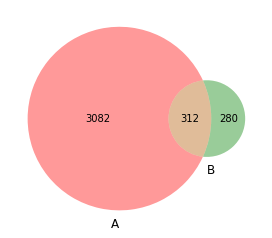

In [18]:
venn2([set(truth),set(pred)])

In [3]:
def recall(truth, pred):    
    return len(truth & pred) / float(len(truth))
    
def precision(truth, pred):
    return len(truth & pred) / float(len(pred))

In [5]:
precision(set(truth), set(pred))

0.527027027027027

In [19]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(solver='liblinear', penalty='l1', C=200)
classifier = classifier.fit(dataset.values, labels)
coefs = pd.DataFrame(classifier.coef_, columns=dataset.columns)
features = coefs.ix[0, coefs.loc[0].nonzero()[0].tolist()].index.tolist()

/Users/alex/Documents/gslr/venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [20]:
len(features)

533

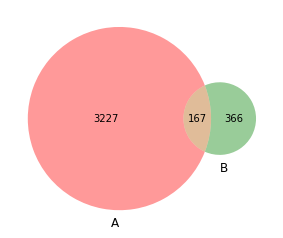

In [21]:
venn2([set(truth),set(features)])